# Modeling Wine Preferences by Data Mining from Physicochemical Properties
In this notebook, we analyze the tasting preferences of "vinho verde", a well known portugese wine from the region Vinho in Portugal. The Data has been assessed by giving different wines to at least three independent sensory assessors who ranked the wine quality on a scale of 0 (very bad) to 10 (very good). The data has been collected over the time span of almost three years from May/2004 to February/2007.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.optimize import curve_fit
from scipy.stats import moment
from itertools import combinations

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from models import DecisionTree, RandomForest, XGBoost

# np.random.seed(42)

# Part 1: Reading and Preparing Data
At first, we have to read in the data. As vinho verde exists as white and red wine, which both have different physiochemical properties, we have two different datasets. The white data set has 4898 entries, the red data set has 1599 entries. As we expect similar results for white and red wine, we start or analysis on the white wine at first and later repeat the same steps for the red wine.

In [19]:
# Paths to data
path_white = '/Users/simonwittum/Documents/Uni/Master/Semester2/DataScience/Project/wine+quality/winequality-white.csv'
path_red = '/Users/simonwittum/Documents/Uni/Master/Semester2/DataScience/Project/wine+quality/winequality-red.csv'

# Load data
df = pd.read_csv(path_red, sep=';')

# Get feature labels
columns = df.columns
labels = np.array(columns)[:-1]
print('Features:', labels, '\n')

# Normalize data to have mean 0 and standard deviation 1
# scaler = StandardScaler()
# data_normalized = scaler.fit_transform(df[labels])
# df_normalized = pd.DataFrame(data_normalized, columns=labels)
# df_normalized = pd.concat([df_normalized, df[df.columns[-1]]], axis=1)

# Extract values and shuffle data
data = df.values
np.random.shuffle(data)
X, y = data[:, :-1], data[:, -1].astype(int)

# Rescale data to have mean 0 and standard deviation 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize data
X_means = np.mean(X, axis=0)
X_stds = np.std(X, axis=0)
X = (X-X_means)/X_stds

# Get number of samples and features
n_samples, n_features = X.shape
print('Number of samples:', n_samples)
print('Number of features:', n_features, '\n')

# Get unique classes
classes = np.unique(y)
print('Classes:', classes, '\n')

# Get normalized data frame
df_normalized = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1), columns=columns)
df_normalized.head()

Features: ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol'] 

Number of samples: 1599
Number of features: 11 

Classes: [3 4 5 6 7 8] 



fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.011282          0.989809    -0.775267        0.043416   0.096353   
1      -0.700719         -2.054821     0.867948       -0.027532  -0.413736   
2       0.850513         -1.049255     0.611196       -0.807957  -0.456244   
3      -0.413454         -1.328579     1.124700        0.114364   0.096353   
4      -1.390155         -1.328579    -0.107711        7.705778  -0.434990   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.370562             -0.561586  1.406296  1.288643   0.365003   
1             0.107592             -0.470360 -1.837387  0.251958  -0.697233   
2            -1.231239             -1.200175 -1.084768 -0.784726  -0.638220   
3             0.872638              0.411500  0.187265 -0.007213  -0.284141   
4             5.367284              3.452397  0.245566  0.122373  -0.697233   

    alcohol  quality  
0 -0.397043      5.0  
1  1.855771      6.0  
2  0.917099      7.0  
3 -0.303175      6.0  
4 -0.115441      6.0

## Part 2: Short Preanalysis
At first, let us take a look at the distribution of wine qualities in the data set. As we can see, almost all wines are classified between 5 and 9. 

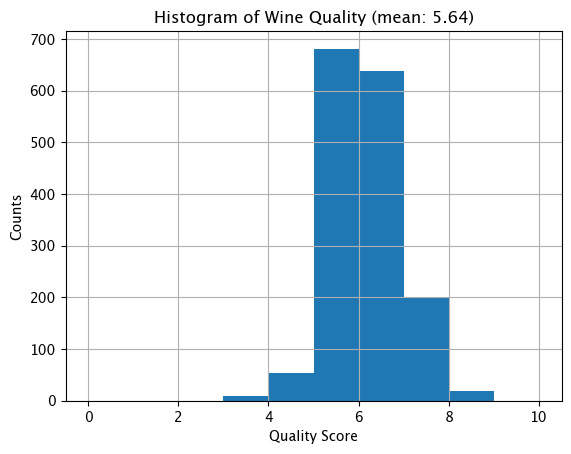

In [20]:
y_mean = np.mean(y)

plt.title(f'Histogram of Wine Quality (mean: {y_mean:.2f})')
plt.hist(y, range(0, 11, 1))
plt.xlabel('Quality Score')
plt.ylabel('Counts')
plt.grid()

Next, let us take a look at the correlation matrix. Remember that the Pearson correlation coefficient between two quantities is defined as 
\begin{equation}
    C(x, y) = \frac{\mathrm{cov}(x, y)}{\sigma_x \sigma_y},
\end{equation}
where $\mathrm{cov}(x, y)$ denotes the covariance given by
\begin{equation}
    \mathrm{cov}(x, y) = \langle(x-\langle x \rangle)(y-\langle y \rangle)\rangle
\end{equation}
and $\sigma_x$ and $\sigma_y$ the standard deviations belonging to $x$ and $y$.

Correlated features: [('fixed acidity', 'citric acid'), ('fixed acidity', 'density'), ('fixed acidity', 'pH'), ('volatile acidity', 'citric acid'), ('citric acid', 'pH'), ('free sulfur dioxide', 'total sulfur dioxide')] 



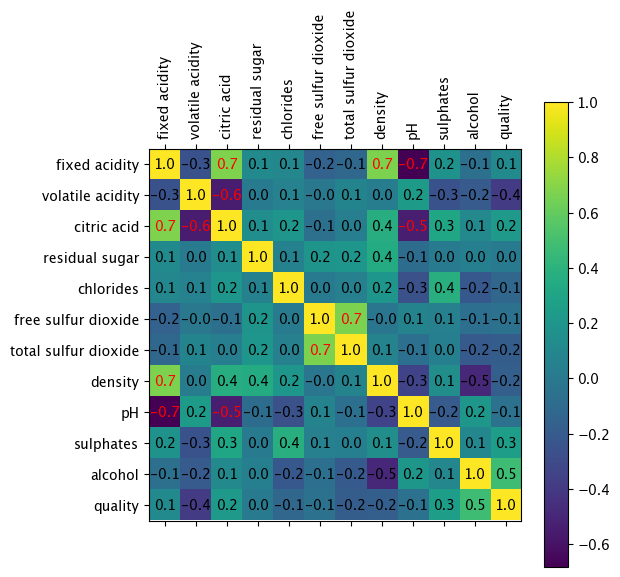

In [21]:
corr = df_normalized.corr()
plt.figure(figsize=(6, 6))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(columns)), columns, rotation='vertical')
plt.yticks(range(len(columns)), columns)
plt.colorbar()

for i in range(len(columns)):
    for j in range(len(columns)):
        if np.abs(corr.iloc[i, j]) < 0.5 or i == j:
            plt.text(j, i, f"{corr.iloc[i, j]:.1f}", ha='center', va='center', color='black')
        else:
            plt.text(j, i, f"{corr.iloc[i, j]:.1f}", ha='center', va='center', color='red')
        
correlated = []
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        if abs(corr.iloc[i, j]) > 0.5:
            correlated.append((columns[i], columns[j]))
print('Correlated features:', correlated, '\n')

We see that we have more correlated tuples than in the case of white wine. Let us analyze the strongest correlations in the following.

/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


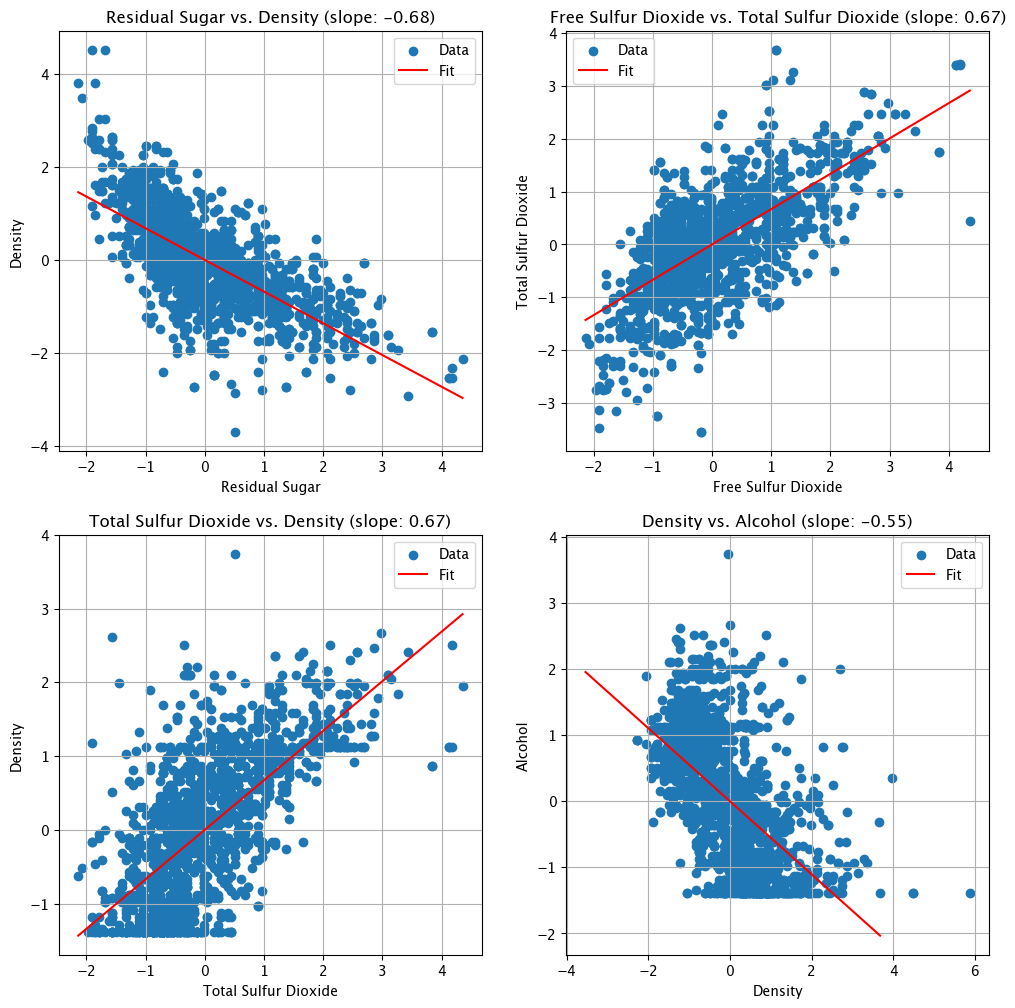

In [22]:
n_correlations = len(correlated)
fixed_acidity = df_normalized['fixed acidity'].values
pH = df_normalized['pH'].values
density = df_normalized['density'].values
citric_acid = df_normalized['citric acid'].values
volatile_acidity = df_normalized['volatile acidity'].values

def linear_func(x, a, b):
    return a*x+b

popt_fapH, pcov_fapH = curve_fit(linear_func, fixed_acidity, pH)
popt_fad, pcov_fad = curve_fit(linear_func, fixed_acidity, density)
popt_faca, pcov_faca = curve_fit(linear_func, fixed_acidity, citric_acid)
popt_vaca, pcov_vaca = curve_fit(linear_func, volatile_acidity, citric_acid)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

x = np.linspace(fixed_acidity.min(), fixed_acidity.max(), 100)
ax[0, 0].scatter(fixed_acidity, pH, label='Data')
ax[0, 0].plot(x, linear_func(x, *popt_fapH), 'r-', label='Fit')
ax[0, 0].set_title(f'Residual Sugar vs. Density (slope: {popt_fapH[0]:.2f})')
ax[0, 0].set_xlabel('Residual Sugar')
ax[0, 0].set_ylabel('Density')
ax[0, 0].legend()
ax[0, 0].grid()

x = np.linspace(fixed_acidity.min(), fixed_acidity.max(), 100)
ax[0, 1].scatter(fixed_acidity, density, label='Data')
ax[0, 1].plot(x, linear_func(x, *popt_fad), 'r-', label='Fit')
ax[0, 1].set_title(f'Free Sulfur Dioxide vs. Total Sulfur Dioxide (slope: {popt_fad[0]:.2f})')
ax[0, 1].set_xlabel('Free Sulfur Dioxide')
ax[0, 1].set_ylabel('Total Sulfur Dioxide')
ax[0, 1].legend()
ax[0, 1].grid()

x = np.linspace(fixed_acidity.min(), fixed_acidity.max(), 100)
ax[1, 0].scatter(fixed_acidity, citric_acid, label='Data')
ax[1, 0].plot(x, linear_func(x, *popt_faca), 'r-', label='Fit')
ax[1, 0].set_title(f'Total Sulfur Dioxide vs. Density (slope: {popt_faca[0]:.2f})')
ax[1, 0].set_xlabel('Total Sulfur Dioxide')
ax[1, 0].set_ylabel('Density')
ax[1, 0].legend()
ax[1, 0].grid()

x = np.linspace(density.min(), density.max(), 100)
ax[1, 1].scatter(volatile_acidity, citric_acid, label='Data')
ax[1, 1].plot(x, linear_func(x, *popt_vaca), 'r-', label='Fit')
ax[1, 1].set_title(f'Density vs. Alcohol (slope: {popt_vaca[0]:.2f})')
ax[1, 1].set_xlabel('Density')
ax[1, 1].set_ylabel('Alcohol')
ax[1, 1].legend()
ax[1, 1].grid()

to_drop = ['residual sugar', 'free sulfur dioxide', 'density']

Let us finally take a look at the shape of the distribution of the features. If the distribution of a feature has hardly any variation, the impact of the feature on the training process is probably rather small. In the beginning, we normalized each feature to obey $\mu=0$ and $\sigma=1$. In order to measure the smearness, we need to consult higher order moments. In this example, we stick with the 4th moment. Using the 4th moment as a measure for smearness, we find that the two least smeared features are:

- alcohol
- pH

In contrast, the two features with the biggest smearing are:

- free sulfur dioxide
- chlorides

quality  citric acid   alcohol        pH   density  fixed acidity  \
min       3.000000    -1.391472 -1.898919 -3.700401 -3.538731      -2.137045   
max       8.000000     3.743574  4.202453  4.528282  3.680055       4.355149   
moment 1  0.000000     0.000000  0.000000  0.000000  0.000000       0.000000   
moment 3  0.114495     0.318039  0.860021  0.193502  0.071221       0.981829   
moment 4  1.398428     2.209717  3.195654  3.800671  3.927411       4.124856   

          volatile acidity  free sulfur dioxide  total sulfur dioxide  \
min              -2.278280            -1.422500             -1.230584   
max               5.877976             5.367284              7.375154   
moment 1          0.000000             0.000000              0.000000   
moment 3          0.670962             1.249394              1.514109   
moment 4          4.217963             5.013490              6.794172   

          sulphates  residual sugar  chlorides  
min       -1.936507       -1.162696  -1.603945  
max        7.918677        9.195681  11.127035  
moment 1   0.000000        0.000000   0.000000  
moment 3   2.426393        4.536395   5.675017  
moment 4  14.679884       31.524438  44.581708

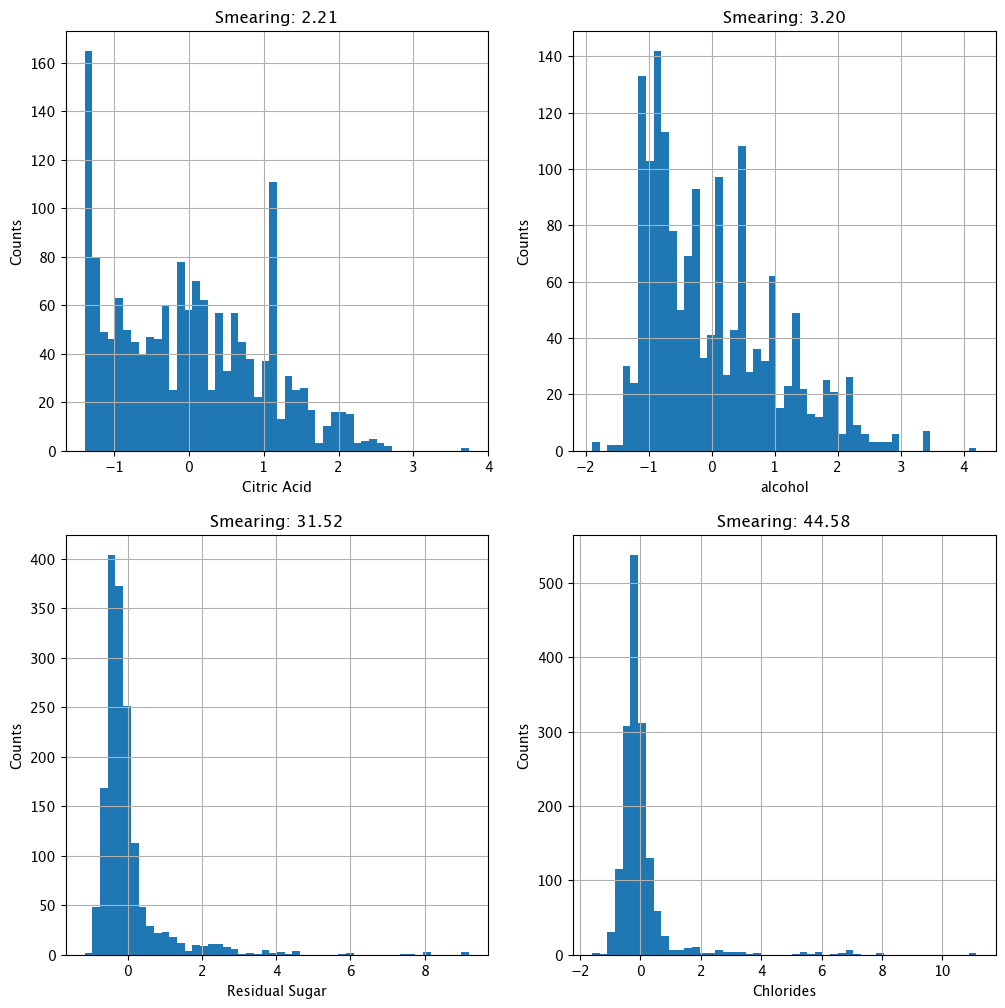

In [23]:
columns_df = pd.DataFrame(columns=columns)

columns_min = {column_name: np.min(df_normalized[column_name]) for column_name in columns}
columns_max = {column_name: np.max(df_normalized[column_name]) for column_name in columns}
columns_mean = {column_name: np.mean(df_normalized[column_name]) for column_name in columns}
columns_moment1 = {column_name: moment(df_normalized[column_name], moment=1) for column_name in columns}
columns_moment2 = {column_name: moment(df_normalized[column_name], moment=2) for column_name in columns}
columns_moment3 = {column_name: moment(df_normalized[column_name], moment=3) for column_name in columns}
columns_moment4 = {column_name: moment(df_normalized[column_name], moment=4) for column_name in columns}

columns_df.loc['min'] = columns_min
columns_df.loc['max'] = columns_max
# columns_df.loc['mean'] = columns_mean # This is normalized to 0!
columns_df.loc['moment 1'] = columns_moment1
# columns_df.loc['moment 2'] = columns_moment2 # This is normalized to 1!
columns_df.loc['moment 3'] = columns_moment3
columns_df.loc['moment 4'] = columns_moment4

# Sort data by moment 4
columns_df = columns_df.sort_values(by='moment 4', axis=1, ascending=True)

display(columns_df)

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].hist(df_normalized['citric acid'], bins=50)
# ax[0, 0].set_title(rf'Alcohol ($\mu_4={columns_moment4["alcohol"]:.2f}$)')
ax[0, 0].set_title(f'Smearing: {columns_moment4["citric acid"]:.2f}')
ax[0, 0].set_xlabel('Citric Acid')
ax[0, 0].set_ylabel('Counts')
ax[0, 0].grid()

ax[0, 1].hist(df_normalized['alcohol'], bins=50)
ax[0, 1].set_title(f'Smearing: {columns_moment4["alcohol"]:.2f}')
ax[0, 1].set_xlabel('alcohol')
ax[0, 1].set_ylabel('Counts')
ax[0, 1].grid()

ax[1, 0].hist(df_normalized['residual sugar'], bins=50)
ax[1, 0].set_title(f'Smearing: {columns_moment4["residual sugar"]:.2f}')
ax[1, 0].set_xlabel('Residual Sugar')
ax[1, 0].set_ylabel('Counts')
ax[1, 0].grid()

ax[1, 1].hist(df_normalized['chlorides'], bins=50)
ax[1, 1].set_title(f'Smearing: {columns_moment4["chlorides"]:.2f}')
ax[1, 1].set_xlabel('Chlorides')
ax[1, 1].set_ylabel('Counts')
ax[1, 1].grid()

## Part 2: Analysis
Having loaded the data, we are ready to perform the actual analysis. In the last team meeting, we decided to analyse the data with different models, and distributed them as follows:

- Neural Networks (Yushu An & Zhaoyu Wang)
- Regression Models (Giuseppe Calabrese & Richard Rippel)
- Decision Trees (Simon Wittum)

Therefore, in this notebook, the data will be analysed using decision trees.

In [24]:
# Due to strong correlations, we drop the following columns:
to_drop = ['residual sugar', 'free sulfur dioxide', 'density']


def get_accuracy_off(conf_matrix, off=1):
    n, _ = conf_matrix.shape
    acc = 0
    for i in range(n):
        for j in range(n):
            if np.abs(i-j) <= off:
                acc += conf_matrix[i, j]
    return acc/np.sum(conf_matrix)


def perform_analysis(model, path=path_white):
    """
    Takes a model and a path to a dataset and performs a cross validation and train-test split analysis. It prints
    the results from the cross validation, the accuracy on the training and testing data and the classification report.
    Furthermore, it plots the confusion matrix of the classifier.

    Parameters:
    - model (Classifier): Model to be used for classification
    - path (str): Path to the dataset

    Returns:
    - accuracy_test (float): Accuracy on the testing data and the confusion matrix
    - conf_matrix (ndarray): Confusion matrix of the classifier
    """
    # Load data
    df = pd.read_csv(path, sep=';')
    labels = np.array(df.columns)[:-1]

    # Normalize data to have mean 0 and standard deviation 1
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(df[labels])
    df_normalized = pd.DataFrame(data_normalized, columns=labels)
    df_normalized = pd.concat([df_normalized, df[df.columns[-1]]], axis=1)

    # Remove correlated features
    # df.drop(to_drop, inplace=True, axis=1)

    # Extract values and shuffle data
    data = df.values
    np.random.shuffle(data)
    X, y = data[:, :-1], data[:, -1]

    # Label encoding (required for XGBoost model)
    le = LabelEncoder()
    y = le.fit_transform(y)    

    # Starting with cross validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_score_mean = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('Cross validation:')
    print(f'Cross-Validation Scores: {cv_scores}')
    print(f'Mean Accuracy: {100*cv_score_mean:.2f}%')
    print(f'Standard Deviation: {100*cv_score_std:.2f}%')

    # Using static train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    # Accuracy on training data
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Accuracy on test data
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    print('\nTrain Test Split:')
    print(f'Accuracy on Training Data: {100*accuracy_train:.2f}%')
    print(f'Accuracy on Testing Data: {100*accuracy_test:.2f}%')

    # Inverse transform label encoding
    y_test = le.inverse_transform(y_test)
    y_pred_test = le.inverse_transform(y_pred_test)

    # Classification report
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred_test))

    # Confusion matrix        
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    plt.figure()
    plt.imshow(conf_matrix, cmap='Blues')

    # Get accuracy within 1
    accuracy_off = get_accuracy_off(conf_matrix, off=1)
    print(f'Accuracy within 1: {100*accuracy_off:.2f}%')

    # Add count values to each cell
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

    # plt.colorbar()
    plt.xlabel('Model Predictions')
    plt.ylabel('Real Values')
    plt.xticks(range(len(classes)), classes)
    plt.yticks(range(len(classes)), classes)
    plt.title('Confusion Matrix Red Wine')
    plt.savefig('./conf_matrix_red.png', dpi=300)
    plt.show()

    return accuracy_test, conf_matrix

### Decision Tree
Let us first start by analysing ordinary decision trees. It is a well known fact that while decision trees have the ability to very accurately classify data, they struggle to generalize, i.e. they have a very high variance. This is also true in our case: The tree achieves a 100% accuracy on the training data, but only 60% on the testing data.

Cross validation:
Cross-Validation Scores: [0.65625    0.58125    0.6125     0.64375    0.62382445]
Mean Accuracy: 62.35%
Standard Deviation: 2.60%

Train Test Split:
Accuracy on Training Data: 100.00%
Accuracy on Testing Data: 63.12%

Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         5
         4.0       0.33      0.18      0.24        11
         5.0       0.64      0.72      0.68       120
         6.0       0.68      0.62      0.65       141
         7.0       0.52      0.60      0.56        40
         8.0       0.50      0.33      0.40         3

    accuracy                           0.63       320
   macro avg       0.45      0.41      0.42       320
weighted avg       0.62      0.63      0.62       320

Accuracy within 1: 94.38%


/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


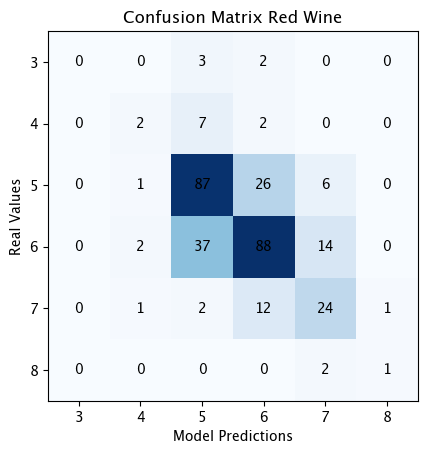

In [25]:
# Remember: Recall = True Positive Rate
DT = DecisionTreeClassifier(random_state=42)
accuracy_dt, conf_matrix = perform_analysis(DT, path=path_red)

### Histogram for Performance of DT
We are now going to analyze the performance from the DT with more care by taking a closer look at the 
resulting confusion matrix.

<BarContainer object of 6 artists>

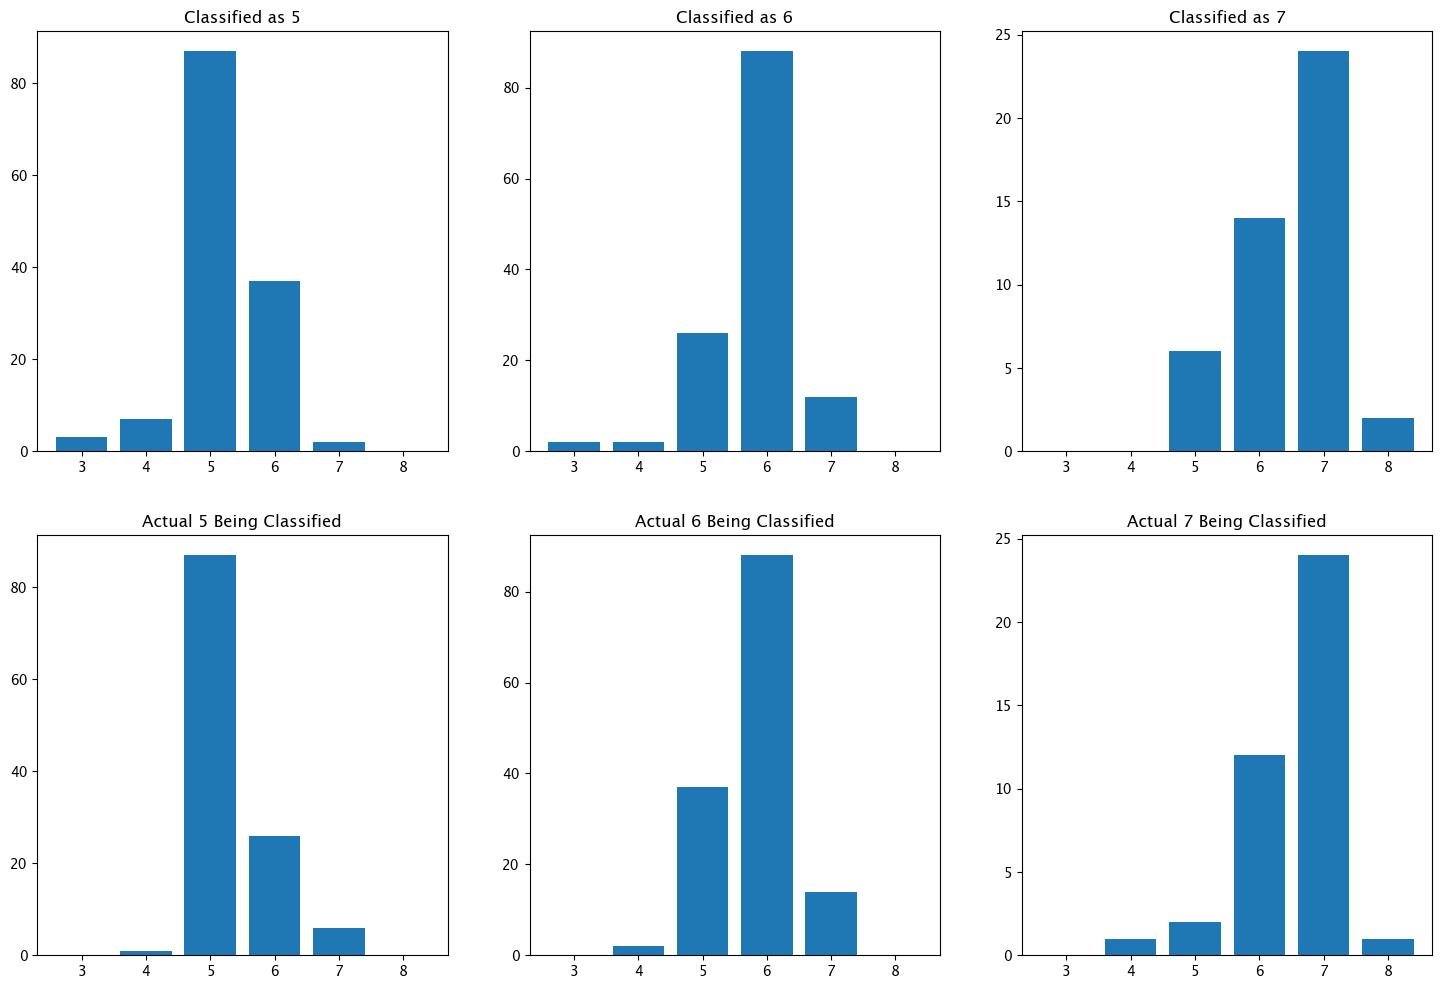

In [26]:
x_axis = np.array([3, 4, 5, 6, 7, 8])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

ax[0, 0].set_title('Classified as 5')
ax[0, 0].bar(x_axis, conf_matrix[:, 2])

ax[0, 1].set_title('Classified as 6')
ax[0, 1].bar(x_axis, conf_matrix[:, 3])

ax[0, 2].set_title('Classified as 7')
ax[0, 2].bar(x_axis, conf_matrix[:, 4])

ax[1, 0].set_title('Actual 5 Being Classified')
ax[1, 0].bar(x_axis, conf_matrix[2])

ax[1, 1].set_title('Actual 6 Being Classified')
ax[1, 1].bar(x_axis, conf_matrix[3])

ax[1, 2].set_title('Actual 7 Being Classified')
ax[1, 2].bar(x_axis, conf_matrix[4])

### Random Forest Simulation
In order to avoid the problem of overfitting frequently encountered with ordinary decision trees, it is a common strategy to use mutliple decision trees and train them over different parts of a given training dataset. In order to test the model, the test data is passed to each decision tree, and the overall prediction is computed by averaging over the predictions of each individual decision tree. This method goes under the name of "random forest simulation", or for an arbitrary training model, "bagging".

Cross validation:
Cross-Validation Scores: [0.709375   0.665625   0.721875   0.696875   0.69592476]
Mean Accuracy: 69.79%
Standard Deviation: 1.87%

Train Test Split:
Accuracy on Training Data: 100.00%
Accuracy on Testing Data: 67.19%

Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00        13
         5.0       0.77      0.78      0.77       136
         6.0       0.62      0.70      0.66       128
         7.0       0.51      0.51      0.51        37
         8.0       0.00      0.00      0.00         3

    accuracy                           0.67       320
   macro avg       0.32      0.33      0.32       320
weighted avg       0.63      0.67      0.65       320

Accuracy within 1: 96.88%


/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


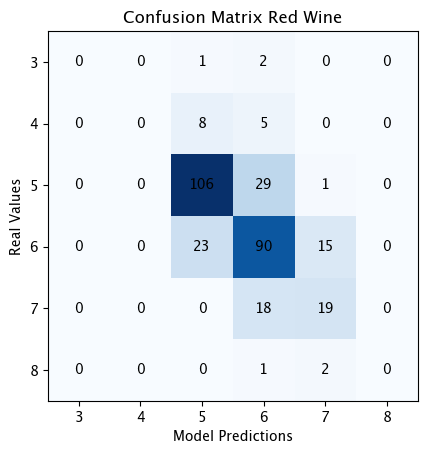

In [27]:
RF = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
accuracy_rf, conf_matrix_RF = perform_analysis(RF, path=path_red)

### Boosted Decision Tree
We are now going to consider another option to get around the high variance problem of decision trees, which goes under the name of boosting. The idea is to take 

Cross validation:
Cross-Validation Scores: [0.646875   0.665625   0.659375   0.7375     0.68338558]
Mean Accuracy: 67.86%
Standard Deviation: 3.17%

Train Test Split:
Accuracy on Training Data: 100.00%
Accuracy on Testing Data: 70.94%

Classification Report:
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00        12
         5.0       0.73      0.83      0.78       130
         6.0       0.70      0.73      0.72       130
         7.0       0.67      0.56      0.61        43
         8.0       0.00      0.00      0.00         3

    accuracy                           0.71       320
   macro avg       0.35      0.35      0.35       320
weighted avg       0.67      0.71      0.69       320

Accuracy within 1: 95.62%


/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonwittum/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


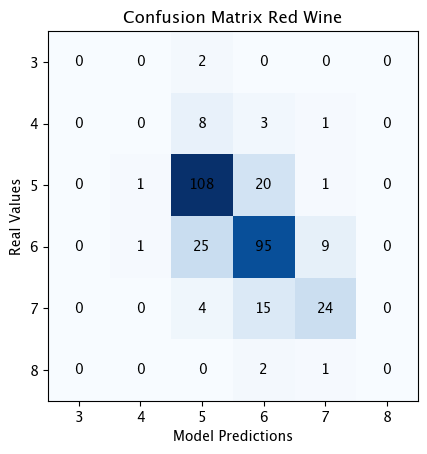

In [28]:
BDT = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=42)
accuracy_bdt, conf_matrix_bdt = perform_analysis(BDT, path=path_red)

## Part 3: Summary
At this point, we have tested three different models and can now compare their performances. The results
are as follows:

In [29]:
print(f'Accuracy Decision Tree: {100*accuracy_dt:.2f}%')
print(f'Accuracy Random Forest: {100*accuracy_rf:.2f}%')
print(f'Accuracy Boosted Decision Tree: {100*accuracy_bdt:.2f}%')

Accuracy Decision Tree: 63.12%
Accuracy Random Forest: 67.19%
Accuracy Boosted Decision Tree: 70.94%


## Part 4: Sensitivity Analysis
So far, we have only fitted different models to the data, without analysing the relevance of the individual features. This is exactly what we are going to do now. In order to do this, we will follow two different approaches:

1. We pick a particular feature $f_j$ and set all other features $f_i$ with $i \neq j$ to their average value. For the selected feature, we extract its minimal and maximal value from the data and ramp the feature linearly within this range for $n$ different points. For each point, we let our model infer a prediction and store the result in a list. In the end, we compute the variance of the prediction array. This procedure is being repeated for all other features and in the end, we can compare the variances with each other. The feature with the highest variance has the biggest influence on the inference and can therefore be identified with the most important input feature. Similarly, the feature with the smallest variance has the least influence on the model and can therefore be considered least important (this is inspired by the research paper at hand).
2. We can also go the other way: We remove arbitrary features from the data and then perform the training and inference on the reduced data set. We repeat this for different combinations of input features and compare the respective accuracies. The combination of removed input features that has the biggest influence on the accuracy can be considered most important (this procedure has been recommended by the lecturers).

## Method 1

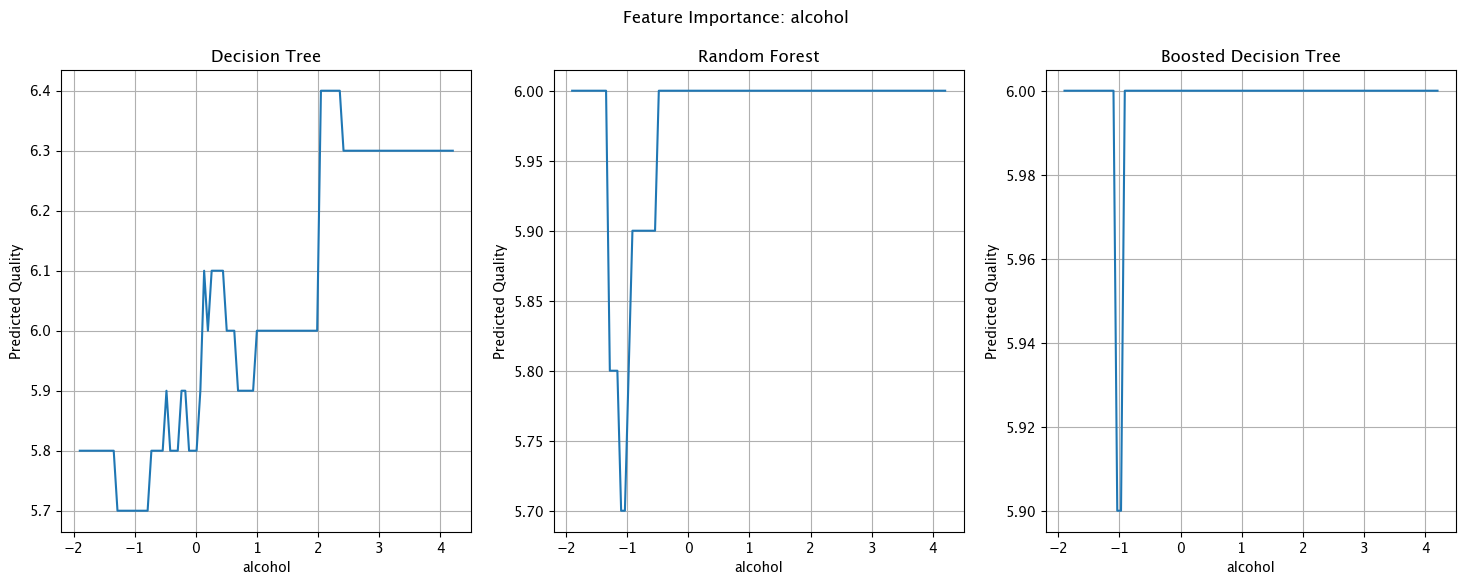

In [30]:
# Implementation of method 1

# Reloading data
df = pd.read_csv(path_red, sep=';')
columns = df.columns
labels = np.array(columns)[:-1]

# Normalize data to have mean 0 and standard deviation 1
scaler = StandardScaler()
data_normalized = scaler.fit_transform(df[labels])
df_normalized = pd.DataFrame(data_normalized, columns=labels)
df_normalized = pd.concat([df_normalized, df[df.columns[-1]]], axis=1)

# Drop columns
# to_drop = ['residual sugar', 'free sulfur dioxide', 'density']
# df_normalized.drop(to_drop, inplace=True, axis=1)
# columns_reduced = df_normalized.columns
# labels_reduced = np.array(columns_reduced)[:-1]
labels_reduced = labels

# Shuffle data and extract features and labels
data = df_normalized.values
np.random.shuffle(data)
X, y = data[:, :-1], data[:, -1].astype(int)
n_samples, n_features = X.shape

# Initialize label encoder
le = LabelEncoder()


def get_feature_importance(feature_index, model, n_averages=10):
    average_input = np.mean(X, axis=0)
    # Maybe use median?
    # average_input = np.median(X, axis=0)
    feature = X[:, feature_index]
    n_tests = 100
    feature_values = np.linspace(np.min(feature), np.max(feature), n_tests)
    values = np.zeros((n_tests, n_features))
    for i in range(n_tests):
        values[i] = average_input
        values[i, feature_index] = feature_values[i]
    predictions = np.zeros((n_averages, n_tests))
    for i in range(n_averages):
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2)
        y_train = le.fit_transform(y_train)
        model.fit(X_train, y_train)
        predictions[i] = le.inverse_transform(model.predict(values))
    predictions_out = np.mean(predictions, axis=0)
    deviations = np.std(predictions, axis=0)
    return feature_values, predictions_out, deviations


def get_variation_and_error(predictions, deviations):
    n_samples = len(predictions)
    variation = np.var(predictions)
    mean = np.mean(predictions)
    error_mean = 0
    for i in range(n_samples):
        error_mean += deviations[i]**2
    error_mean = np.sqrt(error_mean)/n_samples
    error_R = 0
    for i in range(n_samples):
        error_R += (2*(predictions[i]-mean)/n_samples*deviations[i])**2+(2*(predictions[i]-mean)/n_samples*error_mean)**2
    error_R = np.sqrt(error_R)
    return variation, error_R

        
def get_importances(model, n_averages=10):
    variation = np.zeros(n_features)
    variation_errors = np.zeros(n_features)
    for i in range(n_features):
        _, predictions, deviations = get_feature_importance(i, model, n_averages=n_averages)
        variation[i], variation_errors[i] = get_variation_and_error(predictions, deviations)
    total_variation = np.sum(variation)
    total_variation_error = 0
    for i in range(n_features):
        total_variation_error += variation_errors[i]**2
    total_variation_error = np.sqrt(total_variation_error)

    importances = variation/total_variation*100
    importances_errors = np.zeros(n_features)

    for i in range(n_features):
        importances_errors[i] += (variation_errors[i]/total_variation)**2
        importances_errors[i] += (variation[i]/total_variation**2*total_variation_error)**2
        importances_errors[i] = np.sqrt(importances_errors[i])

    return importances, importances_errors

# def get_importances(model, metric='VAR', n_averages=10):
#     variation = np.zeros(n_features)
#     for i in range(n_features):
#         _, predictions = get_feature_importance(i, model, n_averages=n_averages)
#         if metric == 'VAR':
#             variation[i] = np.var(predictions)
#         if metric == 'MAD':
#             variation[i] = np.mean(np.abs(predictions - np.mean(predictions)))
#     total_variation = np.sum(variation)
#     importances = variation/total_variation*100
#     return importances

# feature_index = 3
feature_index = np.where(labels_reduced == 'alcohol')[0][0]
n_averages = 10

# Decision Tree
model = DT
feat_vals_DT, preds_DT, _ = get_feature_importance(feature_index, model, n_averages=n_averages)

# Random Forest
model = RF
feat_vals_RF, preds_RF, _ = get_feature_importance(feature_index, model, n_averages=n_averages)

# Boosted Decision Tree
model = BDT
feat_vals_BDT, preds_BDT, _ = get_feature_importance(feature_index, model, n_averages=n_averages)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Feature Importance: {labels_reduced[feature_index]}')

# DT
ax1.set_title('Decision Tree')
ax1.plot(feat_vals_DT, preds_DT)
ax1.set_xlabel(f'{labels_reduced[feature_index]}')
ax1.set_ylabel('Predicted Quality')
ax1.grid()

# RF
ax2.set_title(f'Random Forest')
ax2.plot(feat_vals_RF, preds_RF)
ax2.set_xlabel(f'{labels_reduced[feature_index]}')
ax2.set_ylabel('Predicted Quality')
ax2.grid()

# BDT
ax3.set_title(f'Boosted Decision Tree')
ax3.plot(feat_vals_BDT, preds_BDT)
ax3.set_xlabel(f'{labels_reduced[feature_index]}')
ax3.set_ylabel('Predicted Quality')
ax3.grid()

In [34]:
n_averages = 10
importances_DT, errors_DT = get_importances(model, n_averages=n_averages)
importances_RF, errors_RF = get_importances(model, n_averages=n_averages)
importances_BDT, errors_BDT = get_importances(model, n_averages=n_averages)

In [35]:
width = 0.2
x_DT = np.arange(n_features)-width
x_RF = np.arange(n_features)
x_BDT = np.arange(n_features)+width

fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Feature Importances')
ax.bar(x_DT, importances_DT, yerr=errors_DT*100, width=width, label='Decision Tree', capsize=2)
ax.bar(x_RF, importances_RF, yerr=errors_RF*100, width=width, label='Random Forest', capsize=2)
ax.bar(x_BDT, importances_BDT, yerr=errors_BDT*100, width=width, label='Boosted Decision Tree', capsize=2)
plt.grid()
plt.xticks(range(n_features), labels_reduced, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.legend()
filepath = '/Users/simonwittum/Documents/Uni/Master/Semester2/DataScience/Project/code/plots/FI_red_all_feats.png'
# plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Save to .csv
importances_df = pd.DataFrame({'Labels': labels_reduced, 'DT': importances_DT, 'RF': importances_RF, 'BDT': importances_BDT,
                               'DT Error': 100*errors_DT, 'RF Error': 100*errors_RF, 'BDT Error': 100*errors_BDT})
importances_df.to_csv('./FI_red.csv', index=False)

## Method 2

(0.0, 1.0)

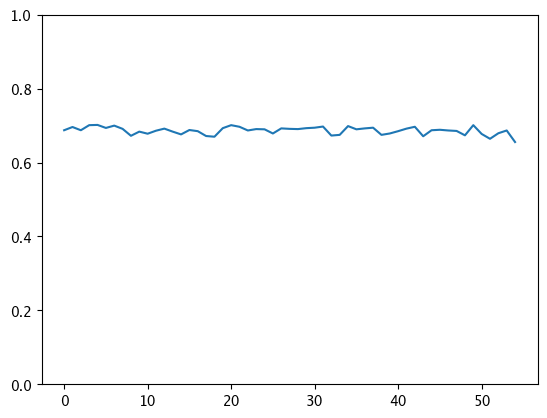

In [ ]:
# Implementation of method 2

# Reloading data
def load_and_process(path):
    df = pd.read_csv(path, sep=';')
    data = df.values
    np.random.shuffle(data)
    X, y = data[:, :-1], data[:, -1].astype(int)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

def combinations_without_replacement(n, m):
    """
    n: number of elements
    m: number of elements to choose
    """
    comb = list(combinations(range(n), m))
    return np.array(comb)

X, y = load_and_process(path_red)
n_samples, n_features = X.shape

def get_accuracy(model, remove_features, n_splits=10):
    X_cleaned = np.delete(X, remove_features, axis=1)
    cv_scores = cross_val_score(model, X_cleaned, y, cv=n_splits, scoring='accuracy')
    cv_score_mean = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    return cv_score_mean, cv_score_std

def get_importances_remove(model, n_splits=10, depth=2):
    combs = combinations_without_replacement(n_features, depth)
    n_combs = combs.shape[0]
    importances = np.zeros(n_combs)
    for i, comb in enumerate(combs):
        to_remove = np.array(comb)
        importances[i] = get_accuracy(model, to_remove, n_splits=n_splits)[0]
    return combs, importances

DT = DecisionTreeClassifier(random_state=42)
RF = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
BDT = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=42)

feats, importances = get_importances_remove(RF, n_splits=5)
n = len(importances)

plt.plot(range(n), importances)
plt.ylim(0, 1)


In [ ]:
df = pd.read_csv(path_red, sep=';')
labels = np.array(df.columns)[:-1]
data = df.values
np.random.shuffle(data)
X, y = data[:, :-1], data[:, -1].astype(int)
n_samples, n_features = X.shape

scaler = StandardScaler()
X = scaler.fit_transform(X)

df_drop = df.drop(to_drop, axis=1)
df_drop.shape

(1599, 9)